In this notebook I will: 
- determine the appropriate parameter step sizes for the numerical derivatives. Mainly we want to get away with the smallest step sizes for $\log M_{\rm min}$ and $\sigma_{\log M}$ due to the halo mass limit of the standard simulations 
- compare the derivatives taken at the fiducial HOD (w/ standard resolution sims) to the derivatives taken at the $M_r < -22$ best-fit HOD (w/ higher resolution sims). If they're similar, that's better since that means we're more or less close to an observed sample

In [1]:
import os 
import scipy as sp 
import numpy as np 
# --- eMaNu --- 
from emanu import util as UT
from emanu import forwardmodel as FM
from emanu.hades import data as hadesData
# -- pyspectrum -- 
from pyspectrum import pyspectrum as pySpec
# --- corrfunc -- 
from Corrfunc.theory import wp as wpCF

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline 

In [3]:
# halo catalogs 
halos = hadesData.hadesMnuHalos(0., 1, 4, mh_min=None, dir='/Users/ChangHoon/data/emanu/halos/hades/0.0eV/1')
Mh_min = np.log10(np.array(halos['Mass']).min()) 
# hi res halo catalog
halos_hires = hadesData.hadesMnuHalos(0., '1_hires', 4, mh_min=None, dir='/Users/ChangHoon/data/emanu/halos/hades/0.0eV/1_hires')

In [4]:
theta_lbls = [r'$\log M_{\rm min}$', r'$\sigma_{\log M}$',r'$\log M_0$',r'$\alpha$',r'$\log M_1$']
hod_fid = np.array([14.22, 0.55, 14.00, 0.87, 14.69]) # fiducial HOD parameters (selected from hod_fiducial.ipynb)
hod_Mr22 = np.array([14.22, 0.77, 14.00, 0.87, 14.69]) # Zheng+(2007) Mr<-22

In [5]:
def pk_model(halos, tt, rsd=True, seed=None): 
    ''' wrapper for populating halos and calculating Pk 
    '''
    # population halos 
    hod = FM.hodGalaxies(halos, {'logMmin': tt[0], 'sigma_logM': tt[1], 'logM0': tt[2], 'alpha': tt[3], 'logM1': tt[4]}, seed=seed)
    # apply RSD 
    if rsd: xyz = FM.RSD(hod) 
    else: xyz = np.array(hod['Position']) 
    # calculate wp 
    _pk = pySpec.Pk_periodic(xyz.T, Lbox=1000, Ngrid=360, fft='pyfftw', silent=True)
    return _pk['k'], _pk['p0k']

rbins = np.array([0.1, 0.15848932, 0.25118864, 0.39810717, 0.63095734, 1., 1.58489319, 2.51188643, 3.98107171, 6.30957344, 10., 15.84893192, 25.11886432]) 
def wp_model(halos, tt, rsd=True, seed=None): 
    ''' wrapper for populating halos and calculating wp 
    '''
    # population halos 
    hod = FM.hodGalaxies(halos, {'logMmin': tt[0], 'sigma_logM': tt[1], 'logM0': tt[2], 'alpha': tt[3], 'logM1': tt[4]}, seed=seed) 
    # apply RSD 
    if rsd: xyz = FM.RSD(hod) 
    else: xyz = np.array(hod['Position']) 
    # calculate wp 
    _wp = wpCF(1000., 40., 1, rbins, xyz[:,0], xyz[:,1], xyz[:,2], verbose=False, output_rpavg=False) 
    return _wp['wp']


def dwpdtheta(halos, tt, dtt, rsd=True, log=True, nreal=1): 
    ''' calculate all dP(k)/dtheta derivatives numerically
    '''
    dwps = [] 
    for i in range(len(tt)): 
        _ttp = tt.copy() 
        _ttm = tt.copy() 
        _ttp[i] = tt[i] + dtt[i] 
        _ttm[i] = tt[i] - dtt[i] 
        wpp, wpm = [], [] 
        for ireal in range(nreal): 
            _wpp = wp_model(halos, _ttp, rsd=rsd, seed=ireal)
            _wpm = wp_model(halos, _ttm, rsd=rsd, seed=ireal)
            wpp.append(_wpp)
            wpm.append(_wpm)
        wpp = np.average(np.array(wpp), axis=0)
        wpm = np.average(np.array(wpm), axis=0) 
        if log: dwp = 0.5*(np.log(wpp) - np.log(wpm))/dtt[i]
        else: dwp = 0.5*(wpp - wpm)/dtt[i]
        dwps.append(dwp) 
    return dwps


def dpkdtheta(halos, tt, dtt, rsd=True, log=True, nreal=1): 
    ''' calculate all dP(k)/dtheta derivatives numerically
    '''
    dpks = [] 
    for i in range(len(tt)): 
        _ttp = tt.copy() 
        _ttm = tt.copy() 
        _ttp[i] = tt[i] + dtt[i] 
        _ttm[i] = tt[i] - dtt[i] 
        pkp, pkm = [], [] 
        for ireal in range(nreal): 
            k, _pkp = pk_model(halos, _ttp, rsd=rsd, seed=ireal)
            k, _pkm = pk_model(halos, _ttm, rsd=rsd, seed=ireal)
            pkp.append(_pkp)
            pkm.append(_pkm)
        pkp = np.average(np.array(pkp), axis=0)
        pkm = np.average(np.array(pkm), axis=0)
        if log: dpk = 0.5*(np.log(pkp) - np.log(pkm))/dtt[i] 
        else: dpk = 0.5*(pkp - pkm)/dtt[i]
        dpks.append(dpk) 
    return k, dpks

Lets calculate the derivatives using the higher resolution halo catalog to deterimine a *sensible* step size. Afterwards, I'll check that there's no significant difference with the lower resolution simulations.

In [6]:
dtt0 = np.array([0.05, 0.05, 0.1, 0.1, 0.05])
dtt1 = np.array([0.075, 0.075, 0.15, 0.15, 0.075])
dtt2 = np.array([0.1, 0.1, 0.2, 0.2, 0.1]) 
dtt3 = np.array([0.15, 0.15, 0.3, 0.3, 0.15])

dlogwps0_hr = dwpdtheta(halos_hires, hod_fid, dtt0, rsd=True, log=True, nreal=10)
dlogwps1_hr = dwpdtheta(halos_hires, hod_fid, dtt1, rsd=True, log=True, nreal=10)
dlogwps2_hr = dwpdtheta(halos_hires, hod_fid, dtt2, rsd=True, log=True, nreal=10)
dlogwps3_hr = dwpdtheta(halos_hires, hod_fid, dtt3, rsd=True, log=True, nreal=10)

/anaconda2/lib/python2.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/anaconda2/lib/python2.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


In [10]:
# get the derivative of wp for the Mr=-22 sample for reference
dlogwps_Mr22 = dwpdtheta(halos_hires, hod_Mr22, dtt1, rsd=True, log=True, nreal=10)

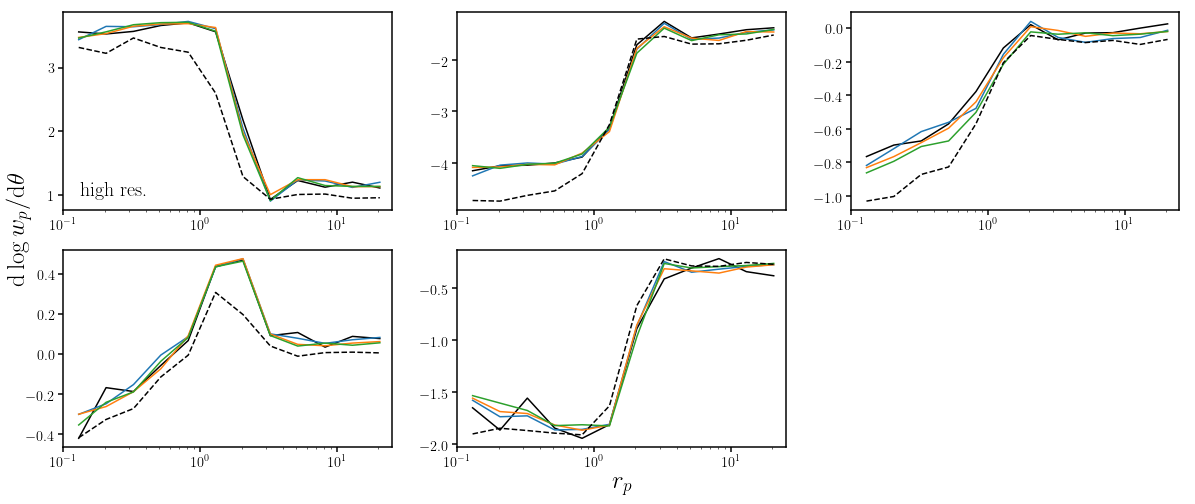

In [12]:
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps0_hr[i], c='k')
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps1_hr[i], c='C0')
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps2_hr[i], c='C1')
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps3_hr[i], c='C2')
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps_Mr22[i], c='k', ls='--')
    
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    if i == 0: sub.text(0.05, 0.05, 'high res.', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log w_p/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

In [8]:
_, dlogpks0_hr = dpkdtheta(halos_hires, hod_fid, dtt0, rsd=True, log=True, nreal=1)
_, dlogpks1_hr = dpkdtheta(halos_hires, hod_fid, dtt1, rsd=True, log=True, nreal=1)
_, dlogpks2_hr = dpkdtheta(halos_hires, hod_fid, dtt2, rsd=True, log=True, nreal=1)
k, dlogpks3_hr = dpkdtheta(halos_hires, hod_fid, dtt3, rsd=True, log=True, nreal=1)

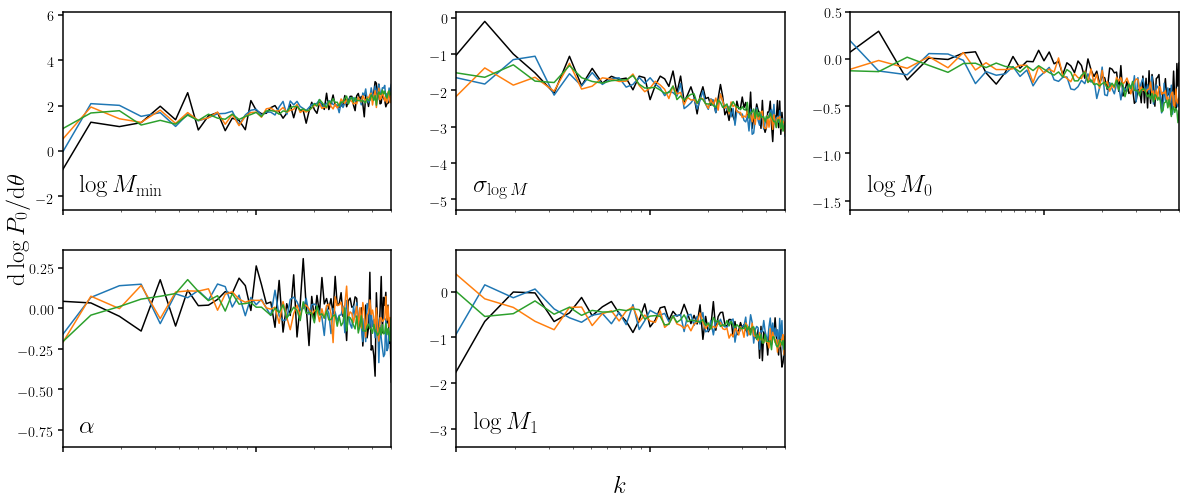

In [9]:
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(k, dlogpks0_hr[i], c='k')
    sub.plot(k, dlogpks1_hr[i], c='C0')
    sub.plot(k, dlogpks2_hr[i], c='C1')
    sub.plot(k, dlogpks3_hr[i], c='C2')

    sub.set_xscale('log') 
    sub.set_xlim(1e-2, 0.5) 
    sub.set_xticklabels([])
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log P_0/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

In [ ]:
dlogwps0_lr = dwpdtheta(halos, hod_fid, dtt0, rsd=True, log=True, nreal=5)
dlogwps1_lr = dwpdtheta(halos, hod_fid, dtt1, rsd=True, log=True, nreal=5)
dlogwps2_lr = dwpdtheta(halos, hod_fid, dtt2, rsd=True, log=True, nreal=5)

In [ ]:
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,5,i+1)
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps0_lr[i], c='k')
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps1_lr[i], c='C0')
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps2_lr[i], c='C1')
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    sub.set_xticklabels([])
    sub.set_title(theta_lbls[i], fontsize=20)
    if i == 0: sub.text(0.05, 0.05, 'std res.', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)
    
    sub = fig.add_subplot(2,5,i+6)
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps0_hr[i], c='k')
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps1_hr[i], c='C0')
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps2_hr[i], c='C1')
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    if i == 0: sub.text(0.05, 0.05, 'high res.', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log w_p/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

In [ ]:
_, dlogpks0_hr = dpkdtheta(halos_hires, hod_fid, dtt0, rsd=True, log=True, nreal=1)
_, dlogpks1_hr = dpkdtheta(halos_hires, hod_fid, dtt1, rsd=True, log=True, nreal=1)
_, dlogpks2_hr = dpkdtheta(halos_hires, hod_fid, dtt2, rsd=True, log=True, nreal=1)

_, dlogpks0_lr = dpkdtheta(halos, hod_fid, dtt0, rsd=True, log=True, nreal=1)
_, dlogpks1_lr = dpkdtheta(halos, hod_fid, dtt1, rsd=True, log=True, nreal=1)
k, dlogpks2_lr = dpkdtheta(halos, hod_fid, dtt2, rsd=True, log=True, nreal=1)

In [ ]:
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,5,i+1)
    sub.plot(k, dlogpks0_lr[i], c='k')
    sub.plot(k, dlogpks1_lr[i], c='C0')
    sub.plot(k, dlogpks2_lr[i], c='C1')
    sub.set_xscale('log') 
    sub.set_xlim(5e-3, 0.5) 
    sub.set_xticklabels([])
    sub.set_title(theta_lbls[i], fontsize=20)
    if i == 0: sub.text(0.05, 0.05, 'std res.', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)
    
    sub = fig.add_subplot(2,5,i+6)
    sub.plot(k, dlogpks0_hr[i], c='k')
    sub.plot(k, dlogpks1_hr[i], c='C0')
    sub.plot(k, dlogpks2_hr[i], c='C1')
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    if i == 0: sub.text(0.05, 0.05, 'high res.', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log P_0/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)